# Doohickey V0.0.2
---
*it's just a doohickey i use for dinking around* <br> 
by [aicrumb](https://twitter.com/aicrumb) <br>


<br> giant credit to [johnowhitaker](https://twitter.com/johnowhitaker) bc most of the sampling code is lifted straight from his "*Grokking Stable Diffusion*" notebook

todo: onnx unet, check if init images are working properly (probably not), thresholding functions (the imagen dynamic function doesn't work, so todo:figure out how to get it to work)

In [1]:
#@title Install required libraries / Log in to 🤗
import os
from IPython.display import clear_output
import time
if not os.path.exists("installed.txt"):
    # red lines, it's fines, that's what i always say
    !pip install transformers diffusers lpips -q
    # !pip install git+https://github.com/openai/CLIP -q
    !pip install open_clip_torch -q
    !pip install wget -q
    !sudo apt-get install git-lfs
    !cat "test" > installed.txt
    print("Installed libraries")
    time.sleep(1) # just so that the user can see a glimpse of the print to know it went succesfuly
    clear_output(wait=False)
else:
    print("Libraries already installed.")

#@markdown base stable diffusion is "CompVis/stable-diffusion-v1-4" 
# if anyone has a script to convert the ckpt files into a format like the other huggingface models, i'd love the trinart model here
model_name = "hakurei/waifu-diffusion" #@param ["hakurei/waifu-diffusion", "CompVis/stable-diffusion-v1-4", "CompVis/stable-diffusion-v1-3", "CompVis/stable-diffusion-v1-2", "CompVis/stable-diffusion-v1-1", "rinna/japanese-stable-diffusion"]

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [2]:
#@title Import libraries
import torch
torch.manual_seed(0)
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import Image, display
from tqdm.auto import tqdm, trange
from torch import autocast
import PIL.Image as PImage
import numpy
from torchvision import transforms
import torchvision.transforms.functional as f
import random
import requests
from io import BytesIO

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
offload_device = "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
#@title Download Models / Enable Attention Slicing

#@markdown attention slicing makes it so that, in pipelines, generating only requries 3.2GB of vram, at a 10% speed decrease <br>
#@markdown reported here: https://huggingface.co/blog/diffusers-2nd-month#optimizations-for-smaller-gpus

attention_slicing = True #@param {"type":"boolean"}

vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=True)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", use_auth_token=True)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=True)

if attention_slicing:
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(offload_device).half()
text_encoder = text_encoder.to(offload_device).half()
unet = unet.to(torch_device).half()

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [4]:
#@title Set up generation loop

to_tensor_tfm = transforms.ToTensor()

# mismatch of tons of image encoding / decoding / loading functions i cant be asked to clean up right now

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
      with autocast("cuda"):
        latent = vae.encode(to_tensor_tfm(input_im.convert("RGB")).unsqueeze(0).to(torch_device)*2-1).latent_dist # Note scaling
#   print(latent)
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

def get_latent_from_url(url, size=(512,512)):
    response = requests.get(url)
    img = PImage.open(BytesIO(response.content))
    img = img.resize(size).convert("RGB")
    latent = pil_to_latent(img)
    return latent

def scale_and_decode(latents):
    with autocast("cuda"):
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(latents).sample.squeeze(0)
        image = f.to_pil_image((image / 2 + 0.5).clamp(0, 1))
        return image

def fetch(url_or_path):
        if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
            r = requests.get(url_or_path)
            r.raise_for_status()
            fd = io.BytesIO()
            fd.write(r.content)
            fd.seek(0)
            return PImage.open(fd).convert('RGB')
        return PImage.open(open(url_or_path, 'rb')).convert('RGB')

"""
grabs all text up to the first occurrence of ':' 
uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
if ':' has no value defined, defaults to 1.0
repeats until no text remaining
"""
def split_weighted_subprompts(text, split=":"):
    remaining = len(text)
    prompts = []
    weights = []
    while remaining > 0:
        if split in text:
            idx = text.index(split) # first occurrence from start
            # grab up to index as sub-prompt
            prompt = text[:idx]
            remaining -= idx
            # remove from main text
            text = text[idx+1:]
            # find value for weight 
            if " " in text:
                idx = text.index(" ") # first occurence
            else: # no space, read to end
                idx = len(text)
            if idx != 0:
                try:
                    weight = float(text[:idx])
                except: # couldn't treat as float
                    print(f"Warning: '{text[:idx]}' is not a value, are you missing a space?")
                    weight = 1.0
            else: # no value found
                weight = 1.0
            # remove from main text
            remaining -= idx
            text = text[idx+1:]
            # append the sub-prompt and its weight
            prompts.append(prompt)
            weights.append(weight)
        else: # no : found
            if len(text) > 0: # there is still text though
                # take remainder as weight 1
                prompts.append(text)
                weights.append(1.0)
            remaining = 0
    print(prompts, weights)
    return prompts, weights 


# from some stackoverflow comment
import numpy as np
def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)
def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3
def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y
def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here

def sample(args):
    global text_encoder # uugghhhghhghgh
    global vae # UUGHGHHGHGH
    global unet # .hggfkgjks;ldjf
    # prompt = args.prompt
    prompts, weights = split_weighted_subprompts(args.prompt)
    h,w = args.size
    steps = args.steps
    scale = args.scale
    classifier_guidance = args.classifier_guidance
    use_init = len(args.init_img)>1
    if args.seed!=-1:
        seed = args.seed
        generator = torch.manual_seed(seed)
    else:
        seed = random.randint(0,10_000)
        generator = torch.manual_seed(seed)
    print(f"Generating with seed {seed}...")
    
    # tokenize / encode text
    tokens = [tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt") for prompt in prompts]
    with torch.no_grad():
        # move CLIP to cuda
        text_encoder = text_encoder.to(torch_device)
        text_embeddings = [text_encoder(tok.input_ids.to(torch_device))[0].unsqueeze(0) for tok in tokens]
        text_embeddings = [text_embeddings[i]*weights[i] for i in range(len(text_embeddings))]
        text_embeddings = torch.cat(text_embeddings, 0).sum(0)
        max_length = 77
        uncond_input = tokenizer(
            [""], padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        # move it back to CPU so there's more vram for generating
        text_encoder = text_encoder.to(offload_device)
    images = []

    if args.lpips_guidance:
        import lpips
        lpips_model = lpips.LPIPS(net='vgg').to(torch_device)
        init = to_tensor_tfm(fetch(args.init_img).resize(args.size)).to(torch_device)

    for i in trange(args.batches):
        with autocast("cuda"):
            unet = unet.to(torch_device)
            scheduler.set_timesteps(steps)
            if not use_init or args.start_step==0:
                latents = torch.randn(
                    (1, unet.in_channels, h//8, w//8),
                    generator=generator
                )
                latents = latents.to(torch_device)
                latents = latents * scheduler.sigmas[0]
                start_step = args.start_step
            else:
                # Start step
                start_step = args.start_step -1
                start_sigma = scheduler.sigmas[start_step]
                start_timestep = int(scheduler.timesteps[start_step])

                # Prep latents
                vae = vae.to(torch_device)
                encoded = get_latent_from_url(args.init_img)
                if not classifier_guidance:
                    vae = vae.to(offload_device)

                noise = torch.randn_like(encoded)
                sigmas = scheduler.match_shape(scheduler.sigmas[start_step], noise)
                noisy_samples = encoded + noise * sigmas

                latents = noisy_samples.to(torch_device).half()
            
            if args.perlin_multi != 0:
                linx = np.linspace(0, 5, h // 8, endpoint=False)
                liny = np.linspace(0, 5, w // 8, endpoint=False)
                x, y = np.meshgrid(liny, linx)
                p = [np.expand_dims(perlin(x, y, seed=i), 0) for i in range(4)] # reproducable seed
                p = np.concatenate(p, 0)
                p = torch.tensor(p).unsqueeze(0).cuda()
                latents = latents + (p * args.perlin_multi).to(torch_device).half()

                
            for i, t in tqdm(enumerate(scheduler.timesteps), total=steps):
                if i > start_step:
                    latent_model_input = torch.cat([latents]*2)
                    sigma = scheduler.sigmas[i]
                    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

                    with torch.no_grad():
                        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
                    
                    # cfg
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + scale * (noise_pred_text - noise_pred_uncond)

                    # cg
                    if classifier_guidance:
                        # vae = vae.to(torch_device)
                        if vae.device != latents.device:
                            vae = vae.to(latents.device)
                        latents = latents.detach().requires_grad_()
                        latents_x0 = latents - sigma * noise_pred
                        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
                        if args.loss_scale != 0:
                            loss = args.loss_fn(denoised_images) * args.loss_scale
                        else:
                            loss = 0
                            init_losses = lpips_model(denoised_images, init)
                            loss = loss + init_losses.sum() * args.lpips_scale

                        cond_grad = -torch.autograd.grad(loss, latents)[0]
                        latents = latents.detach() + cond_grad * sigma**2
                        # vae = vae.to(offload_device)

                    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
        vae = vae.to(torch_device)
        output_image = scale_and_decode(latents)
        vae = vae.to(offload_device)
        images.append(output_image)

        import gc
        gc.collect()
        torch.cuda.empty_cache()

        images[-1].save("temp.png")
        display(Image("temp.png"))
    return images


In [6]:
#@title load textual-inversion concepts from 🤗 hub

#@markdown `load_full_concepts_library` if turned on will take a While, it loads every single stable diffusion concept on https://huggingface.co/sd-concepts-library <br>
#@markdown `specific_concepts` can be a list of strings, containing the ids of your concepts (from sd-concepts-library or your own repos, example `["sd-concepts-library/my-first-inversion", "sd-concepts-library/my-second-inversion"]` etc.)

load_full_concepts_library = False #@param {"type":"boolean"}

from huggingface_hub import HfApi
import wget
api = HfApi()
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1
        # while(num_added_tokens == 0):
        #     print(f"The tokenizer already contains the token {token}.")
        #     token = f"{token[:-1]}-{i}>"
        #     print(f"Attempting to add the token {token}.")
        #     num_added_tokens = tokenizer.add_tokens(token)
        #     i+=1
        
        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token


if load_full_concepts_library:
    models_list = api.list_models(author="sd-concepts-library", sort="likes", direction=-1)
    models = []

    print("Setting up the public library")
    for model in models_list:
        model_content = {}
        model_id = model.modelId
        model_content["id"] = model_id
        embeds_url = f"https://huggingface.co/{model_id}/resolve/main/learned_embeds.bin"
        os.makedirs(model_id,exist_ok = True)
        if not os.path.exists(f"{model_id}/learned_embeds.bin"):
            try:
                wget.download(embeds_url, out=model_id)
            except:
                continue
        token_identifier = f"https://huggingface.co/{model_id}/raw/main/token_identifier.txt"
        response = requests.get(token_identifier)
        token_name = response.text
        print(f"added {token_name}")
        concept_type = f"https://huggingface.co/{model_id}/raw/main/type_of_concept.txt"
        response = requests.get(concept_type)
        concept_name = response.text
        model_content["concept_type"] = concept_name
        images = []
        model_content["images"] = images

        learned_token = load_learned_embed_in_clip(f"{model_id}/learned_embeds.bin", text_encoder, tokenizer, token_name)
        model_content["token"] = learned_token
        models.append(model_content)

specific_concepts = ["crumb/hq-anthro-concept"] #@param

models = []
for model in specific_concepts:
    print("loading", model)
    model_content = {}
    model_content["id"] = model
    embeds_url = f"https://huggingface.co/{model}/resolve/main/learned_embeds.bin"
    os.makedirs(model,exist_ok = True)
    if not os.path.exists(f"{model}/learned_embeds.bin"):
        try:
            wget.download(embeds_url, out=model)
        except:
            continue
    token_identifier = f"https://huggingface.co/{model}/raw/main/token_identifier.txt"
    response = requests.get(token_identifier)
    token_name = response.text
    print(f"added {token_name}")

    concept_type = f"https://huggingface.co/{model}/raw/main/type_of_concept.txt"
    response = requests.get(concept_type)
    concept_name = response.text
    model_content["concept_type"] = concept_name
    images = []
    model_content["images"] = images

    learned_token = load_learned_embed_in_clip(f"{model}/learned_embeds.bin", text_encoder, tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)



loading crumb/hq-anthro-concept
added <midj-anthro>


In [ ]:
"""
if you have learned_embeds.bin for your concept, you can just uncomment this line (remove the hash sign and space before it), and change "<my-concept>" to be whatever your token is, like "<among-us-imposter>" or whatever you called it
"""

# load_learned_embed_in_clip("learned_embeds.bin", text_encoder, tokenizer, "<my-concept>")


### fun tips
1. if you want to generate from scratch but fit to a general pose / orientation (this works well about 1/8 of the time):
set an init image with the pose, set start step to 0, turn on lpips guidance and classifier guidance (needed for lpips to work), turn loss_scale to 0 and experiment with lpips_scale.
2. dont use clip guidance 'oh the headaches you'll have' coming soon to a dr seuss retailer near you
3. the 'waifu diffusion' model works best on danbooru tags (that's what it was trained on)

Downloading:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

['an anime portrait of a munchkin cat by stanley artgerm lau, wlop, rossdraws, james jean, andrei riabovitchev, marc simonetti, and sakimichan, trending on artstation '] [1.0]
['an anime portrait of a munchkin cat by stanley artgerm lau, wlop, rossdraws, james jean, andrei riabovitchev, marc simonetti, and sakimichan, trending on artstation'] [1.0]
Generating with seed 6754...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

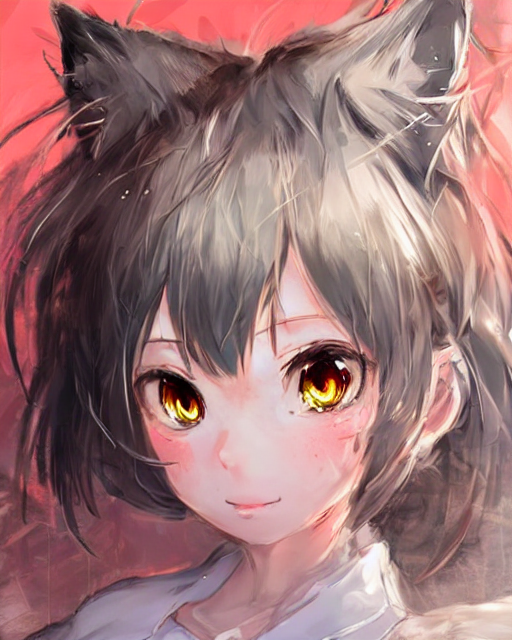

  0%|          | 0/60 [00:00<?, ?it/s]

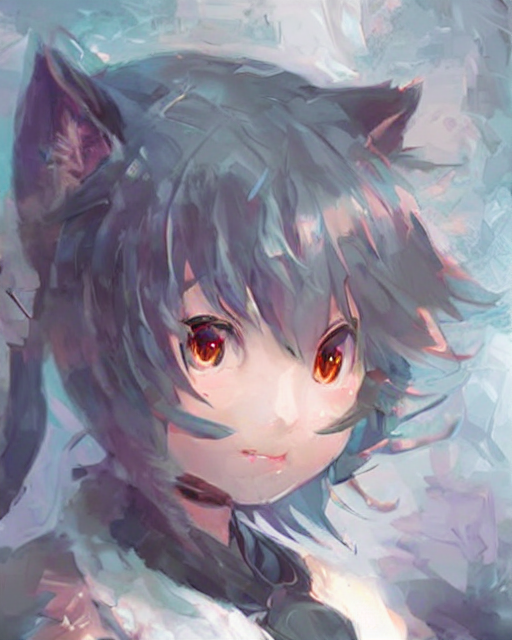

  0%|          | 0/60 [00:00<?, ?it/s]

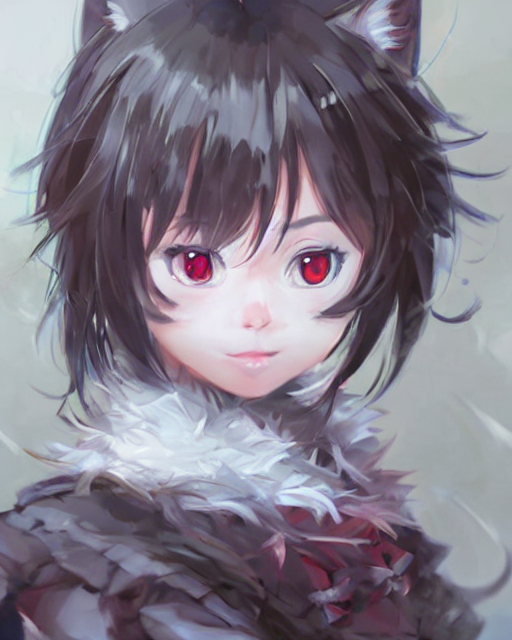

  0%|          | 0/60 [00:00<?, ?it/s]

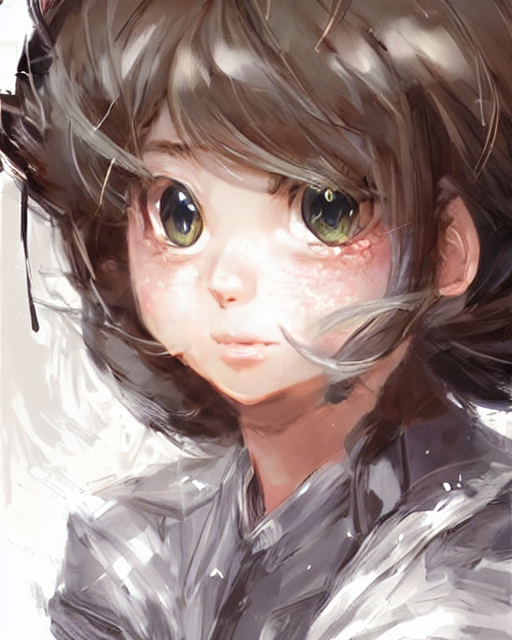

Done!


In [7]:
#@markdown #**Generate**
#@markdown ---
#@markdown ### General Parameters
#@markdown `prompt` can be split into weighted prompts with `prompt1:weight prompt2:weight` <br>
#@markdown `init_img` should be a link to an image, but can be left blank <br>
#@markdown `size` should be a list with height first then width (stable diffusion is trained on images with size `[512,512]`)<br>
#@markdown `steps` can be anything, around 40-80 works for most cases <br>
#@markdown `start_step` is how many steps you skip into the generation, depends on your `steps`, normally use with an `init_img` <br>
#@markdown `perlin_multi` is how much perlin noise to add to the inital image, 0.45 is the maximum i'd use ever and 0.2 seems like a reasonable in-between value <br>
#@markdown `scale` normally should be around 7.5 <br>
#@markdown `seed` can be -1 for a random seed (which will be printed) or set to whatever integer you want <br>
#@markdown `batches` is how many images you want to generate in total <br>


# idk how people normally do this and i cba to look
prompt = "an anime portrait of a munchkin cat by stanley artgerm lau, wlop, rossdraws, james jean, andrei riabovitchev, marc simonetti, and sakimichan, trending on artstation:1" #@param {"type":"string"}
init_img = "" #@param {"type":"string"}
size = [640, 512] #@param
steps = 60 #@param
start_step = 0 #@param
perlin_multi = 0.4 #@param
scale = 7 #@param
seed = -1 #@param
batches = 4 #@param
#@markdown ---

#@markdown ### Classifier Guidance
#@markdown `classifier_guidance` is whether or not to use the loss function in the previous cell to guide the image (slows down image generation a lot) <br>
#@markdown it also is very hit-and-miss in terms of quality, but can be really really good, try setting batches high and then taking a nap <br>
#@markdown `lpips_guidance` is for if you're using an init_img, it'll let you start closer to the beginning while trying to keep the overall shapes similar
#@markdown `lpips_scale` is similar to `loss_scale` but it's how much to push the model to keep the shapes the same <br>
#@markdown `loss_scale` is how much to guide according to that loss function <br>
#@markdown `clip_text_prompt` is a prompt for CLIP to optimize towards, if using classifier guidance (supports weighting with `prompt:weight`) <br>
#@markdown `clip_image_prompt` is an image url for CLIP to optimize towards if using classifier guidance (supports weighting with `url|weight` because of colons coming up in urls) <br>
#@markdown for `clip_model_name` and `clip_model_pretrained` check out the openclip repository https://github.com/mlfoundations/open_clip <br>
#@markdown `cutn` is the amount of permutations of the image to show to clip (can help with stability) <br>
#@markdown *you cannot use the textual inversion tokens with the clip text prompt*  <br>
#@markdown *also clip guidance sucks for most things except removing very small details that dont make sense*
classifier_guidance = True #@param {"type":"boolean"}
lpips_guidance = False #@param {"type":"boolean"}
lpips_scale = 0 #@param
loss_scale = 1. #@param

class BlankClass():
    def __init__(self):
        bruh = 'BRUH'
args = BlankClass()
args.prompt = prompt
args.init_img = init_img
args.size = size 
args.steps = steps 
args.start_step = start_step 
args.scale = scale
args.perlin_multi = perlin_multi
args.seed = seed
args.batches = batches 
args.classifier_guidance = classifier_guidance
args.lpips_guidance = lpips_guidance
args.lpips_scale = lpips_scale
args.loss_scale = loss_scale

if args.classifier_guidance:
    # import clip
    import open_clip as clip
    from torch import nn
    import torch.nn.functional as F
    import io

    class MakeCutouts(nn.Module):
        def __init__(self, cut_size, cutn, cut_pow=1.):
            super().__init__()
            self.cut_size = cut_size
            self.cutn = cutn
            self.cut_pow = cut_pow

        def forward(self, input):
            sideY, sideX = input.shape[2:4]
            max_size = min(sideX, sideY)
            min_size = min(sideX, sideY, self.cut_size)
            cutouts = []
            for _ in range(self.cutn):
                size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
            return torch.cat(cutouts)
    # make_cutouts = MakeCutouts(224, 16)

    clip_text_prompt = "an anime portrait of a munchkin cat by stanley artgerm lau, wlop, rossdraws, james jean, andrei riabovitchev, marc simonetti, and sakimichan, trending on artstation " #@param {"type":"string"}
    clip_image_prompt = "" #@param {"type":"string"}

    if loss_scale != 0:
        # clip_model = clip.load("ViT-B/32", jit=False)[0].eval().requires_grad_(False).to(torch_device)
        clip_model_name = "ViT-H-14" #@param {"type":"string"}
        clip_model_pretrained = "laion2b_s32b_b79k" #@param {"type":"string"}
        clip_model, _, preprocess = clip.create_model_and_transforms(clip_model_name, pretrained=clip_model_pretrained)
        clip_model = clip_model.eval().requires_grad_(False).to(torch_device)

        cutn = 2 #@param
        make_cutouts = MakeCutouts(clip_model.visual.image_size if type(clip_model.visual.image_size)!= tuple else clip_model.visual.image_size[0], cutn)

    target = None
    if len(clip_text_prompt) > 1:
        clip_text_prompt, clip_text_weights = split_weighted_subprompts(clip_text_prompt)
        target = clip_model.encode_text(clip.tokenize(clip_text_prompt).to(torch_device)) * torch.tensor(clip_text_weights).view(len(clip_text_prompt), 1).to(torch_device)
    if len(clip_image_prompt) > 1:
        clip_image_prompt, clip_image_weights = split_weighted_subprompts(clip_image_prompt, split="|")
        # pesky spaces
        clip_image_prompt = [p.replace(" ", "") for p in clip_image_prompt]
        images = [fetch(image) for image in clip_image_prompt]
        images = [f.to_tensor(i).unsqueeze(0) for i in images]
        images = [make_cutouts(i) for i in images]
        encodings = [clip_model.encode_image(i.to(torch_device)).mean(0) for i in images]
        
        for i in range(len(encodings)):
            encodings[i] = (encodings[i] * clip_image_weights[i]).unsqueeze(0)
        # print(encodings.shape)
        encodings = torch.cat(encodings, 0)
        encoding = encodings.sum(0)

        if target!=None:
            target = target + encoding
        else:
            target = encoding
        target = target.half().to(torch_device)

    # free a little memory, we dont use the text encoder after this so just delete it
    clip_model.transformer = None
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    def spherical_distance(x, y):
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()
        return l 

    def loss_fn(x):
        with torch.autocast("cuda"):
            cutouts = make_cutouts(x)
            encoding = clip_model.encode_image(cutouts.float()).half()
            loss = spherical_distance(encoding, target)
            return loss.mean()

    args.loss_fn = loss_fn

#@markdown if your gpu supports torch.bfloat16, you could get up to a 3x speedup (from what i've heard, i cant test this myself)
dtype = torch.float16 #@param
with torch.amp.autocast(device_type=torch_device, dtype=dtype):
    output = sample(args)
print("Done!")

In [8]:
#@markdown ding stolen from big sleep lol, [original author](https://twitter.com/advadnoun)
from google.colab import output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')